In [1]:
import math
import pandas as pd
import numpy as np
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns
import os
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
from sklearn import tree
from sklearn.tree import _tree
from sklearn.ensemble import RandomForestRegressor 
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import GradientBoostingRegressor 
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import warnings
warnings.filterwarnings("ignore")

In [2]:
sns.set()
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

In [3]:
os.chdir("/Users/serrauzun/Desktop/MSDS_422_Practical")
df = pd.read_csv('HMEQ_Loss_clean.csv')

In [4]:
TARGET_F = "TARGET_BAD_FLAG"
TARGET_A = "TARGET_LOSS_AMT"

As our data has already gone through missing data imputation and removal of outliers we can directly start with splitting the dataset for our models

In [5]:
x = df.copy()
x = x.drop( TARGET_F, axis=1 )
x = x.drop( TARGET_A, axis=1 )
y = df[[TARGET_F, TARGET_A]]

Creating a train and test set from both x and y.

In [6]:
x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=0.8, test_size=0.2, random_state=2)

In [7]:
print("FLAG DATA")
print("TRAINING = ", x_train.shape)
print("TEST = ", x_test.shape)

FLAG DATA
TRAINING =  (4688, 20)
TEST =  (1173, 20)


Our training dataset has 4,688 rows and our test dataset has 1,173 rows, which is compliant with our 80/20 split above.

In [8]:
f = ~ y_train[TARGET_A].isna()
w_train = x_train[f].copy()
z_train = y_train[f].copy()

f = ~ y_test[TARGET_A].isna()
w_test = x_test[f].copy()
z_test = y_test[f].copy()

In [9]:
print(z_train.describe())
print(z_test.describe())

       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count      4688.000000      4688.000000
mean          0.196886      2586.748933
std           0.397688      7038.433246
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           0.000000         0.000000
max           1.000000     78987.000000
       TARGET_BAD_FLAG  TARGET_LOSS_AMT
count      1173.000000      1173.000000
mean          0.205456      2690.576300
std           0.404207      7049.842521
min           0.000000         0.000000
25%           0.000000         0.000000
50%           0.000000         0.000000
75%           0.000000         0.000000
max           1.000000     62463.000000


**MODEL ACCURACY METRICS**

In [10]:
def getProbAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    probs = MODEL.predict_proba( X )
    acc_score = metrics.accuracy_score(Y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve( Y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [11]:
def print_ROC_Curve( TITLE, LIST ) :
    fig = plt.figure(figsize=(6,4))
    plt.title( TITLE )
    for theResults in LIST :
        NAME = theResults[0]
        fpr = theResults[2]
        tpr = theResults[3]
        auc = theResults[4]
        theLabel = "AUC " + NAME + ' %0.2f' % auc
        plt.plot(fpr, tpr, label = theLabel )
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

In [12]:
def print_Accuracy( TITLE, LIST ) :
    print( TITLE )
    print( "======" )
    for theResults in LIST :
        NAME = theResults[0]
        ACC = theResults[1]
        print( NAME, " = ", ACC )
    print( "------\n\n" )

In [13]:
def getAmtAccuracyScores( NAME, MODEL, X, Y ) :
    pred = MODEL.predict( X )
    MEAN = Y.mean()
    RMSE = math.sqrt( metrics.mean_squared_error( Y, pred))
    return [NAME, RMSE, MEAN]

                         ** DECISION TREE **

In [14]:
def getTreeVars( TREE, varNames ) :
    tree_ = TREE.tree_
    varName = [ varNames[i] if i != _tree.TREE_UNDEFINED else "undefined!" for i in tree_.feature ]

    nameSet = set()
    for i in tree_.feature :
        if i != _tree.TREE_UNDEFINED :
            nameSet.add( i )
    nameList = list( nameSet )
    parameter_list = list()
    for i in nameList :
        parameter_list.append( varNames[i] )
    return parameter_list

---- DEFAULT PROBABILITY ----

In [15]:
WHO = "TREE"

In [16]:
DFLT = tree.DecisionTreeClassifier(max_depth=4 )
DFLT = DFLT.fit(x_train, y_train[TARGET_F])

In [17]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train, y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test, y_test[TARGET_F])

In [18]:
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

TREE CLASSIFICATION ACCURACY
TREE_Train  =  0.8892918088737202
TREE  =  0.9036658141517476
------




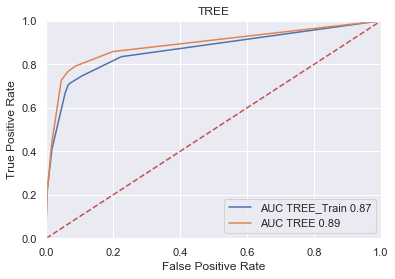

In [19]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 

Both train and test ROC curves are curved towards the True Positive and indicates that our test data is slightly (2%) more accurate than our training data, 87% and 89% respectively. 

In [20]:
feature_cols = list(x.columns.values)
tree.export_graphviz(DFLT,out_file='tree_f.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, class_names=["Good","Bad"] )
vars_tree_flag = getTreeVars(DFLT, feature_cols) 

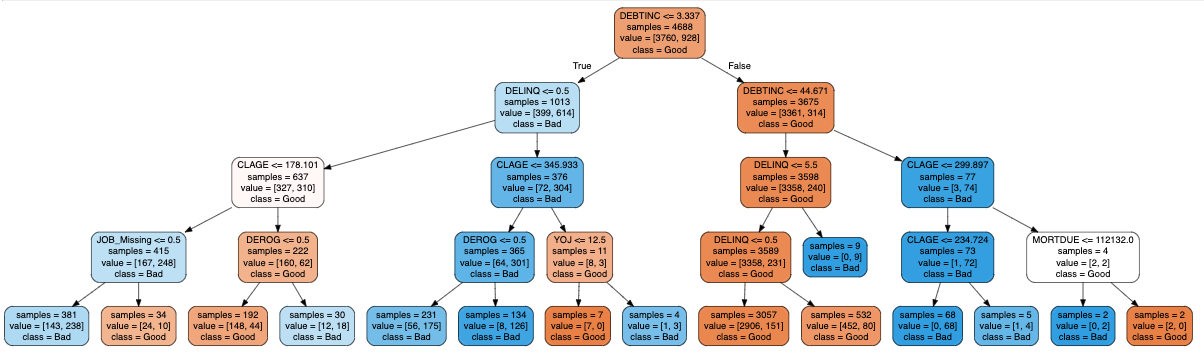

The algorithm we have written have decided to split the data on DEBTINC (Debt to Income Ratio) and 3.337. The data then have incrementally been divided by DELINQ (Delinquencies on your current credit report) and CLAGE (Credit Line Age), then by DEROG (Derogatory Marks on Credit Record), YOJ (Year on Job), JOB (only records with Job as Missing information) and MORTDUE (Current Outstanding Mortgage Balance). Model's chosing of Debt to Income Ratio as the primary indicator does make sense as income is crucial in this context and DEBTINC is the main and only variable related to income. Thus, the obvious correlation between Debt to Income Ratio and the likelihood of credit default is a reasonable outcome of this model that we can accept.

Looking at the Decision Tree our algorithm has given us, we can see that person with DEBTINC less than 3.337, DELINQ less than 0.5, CLAGE less than 346, DEROG less than 0.5 are in the worst class whereas people with DEBTINC higher than 3.357 and less than 44.671, and DELINQ of less than 0.5 are the ones that are least likely to default. 

In [21]:
print( "FLAG=",vars_tree_flag)

FLAG= ['YOJ', 'DEROG', 'DELINQ', 'CLAGE', 'DEBTINC', 'JOB_Missing']


The variables listed above are the top indicators of a possible Home Equity Credit Default

---- LOSS PREDICTION ----

In [22]:
not_zero = y_train[TARGET_A] != 0

In [23]:
w_train = x_train[not_zero]
z_train = y_train[not_zero]

In [24]:
not_zero = y_test['TARGET_LOSS_AMT'] != 0
w_test = x_test[not_zero]
z_test = y_test[not_zero]

In [25]:
AMT = tree.DecisionTreeRegressor(max_depth= 3 )
AMT = AMT.fit(w_train, z_train[TARGET_A])

In [26]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT,w_train,z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

TREE RMSE ACCURACY
TREE_Train  =  5198.885686289661
TREE  =  6065.25844508915
------




It is a positive sign that train and test mean are close to each other. Three seems to be the ideal max_depth for Decision Tree Regressor. Having only 590 difference between test and training means, we can accept this result and continue with the model.

In [27]:
feature_cols = list(x.columns.values)
vars_tree_amt = getTreeVars(AMT, feature_cols) 
tree.export_graphviz(AMT,out_file='tree_a.txt',filled=True, rounded=True, feature_names = feature_cols, impurity=False, precision=0)

In [28]:
TREE_DFLT = TEST_DFLT.copy()
TREE_AMT = TEST_AMT.copy()

**RANDOM FOREST**

In [29]:
def getEnsembleTreeVars( ENSTREE, varNames ) :
    importance = ENSTREE.feature_importances_
    index = np.argsort(importance)
    theList = []
    for i in index :
        imp_val = importance[i]
        if imp_val > np.average( ENSTREE.feature_importances_ ) :
            v = int( imp_val / np.max( ENSTREE.feature_importances_ ) * 100 )
            theList.append( ( varNames[i], v ) )
    theList = sorted(theList,key=itemgetter(1),reverse=True)
    return theList

In [30]:
WHO = "RF"

In [31]:
DFLT = RandomForestClassifier(n_estimators = 25, random_state=1 )
DFLT = DFLT.fit(x_train,y_train[TARGET_F])

In [32]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train, y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test, y_test[TARGET_F])

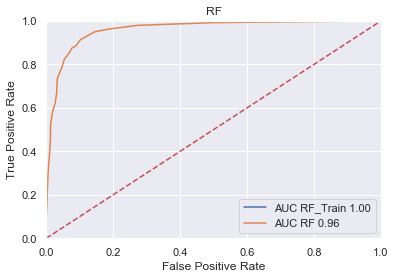

RF CLASSIFICATION ACCURACY
RF_Train  =  0.9982935153583617
RF  =  0.9190110826939472
------




In [33]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

As we had 100 decision trees through out Random Forest Classifier model, we got 100% accuracy on our training set. The training set is not the approperiate indicator of our models indicator, but our test set accuracy is also high, at 92%. Thus, we can say that the random forest classifier model is going to give use an result that is accurate over 90%.  

In [34]:
feature_cols = list(x.columns.values )
vars_RF_flag = getEnsembleTreeVars(DFLT, feature_cols)

**DAMAGES**

In [35]:
AMT = RandomForestRegressor(n_estimators = 100, random_state=1)
AMT = AMT.fit(w_train, z_train[TARGET_A])

In [36]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train, z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

RF RMSE ACCURACY
RF_Train  =  1057.3831014358318
RF  =  4295.973809056954
------




In [37]:
feature_cols = list(x.columns.values )
vars_RF_amt = getEnsembleTreeVars(AMT, feature_cols)

In [38]:
for i in vars_RF_amt :
    print(i)

('LOAN', 100)
('CLNO', 12)
('DEBTINC', 8)


In [39]:
RF_DFLT = TEST_DFLT.copy()
RF_AMT = TEST_AMT.copy()

**GRADIENT BOOSTING**

In [40]:
WHO = "GB"

In [41]:
DFLT = GradientBoostingClassifier(random_state=1 )
DFLT = DFLT.fit(x_train, y_train[TARGET_F])

In [42]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train, y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test, y_test[TARGET_F])

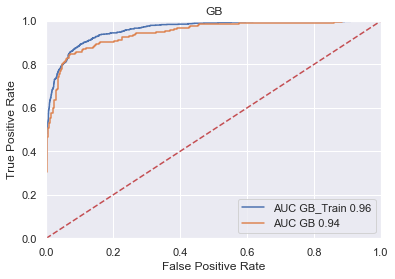

GB CLASSIFICATION ACCURACY
GB_Train  =  0.925981228668942
GB  =  0.9121909633418585
------




In [43]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy( WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

In [44]:
feature_cols = list(x.columns.values )
vars_GB_flag = getEnsembleTreeVars(DFLT, feature_cols)

**DAMAGES**

In [45]:
AMT = GradientBoostingRegressor(random_state=1)
AMT = AMT.fit(w_train, z_train[TARGET_A])

In [46]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train, z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

GB RMSE ACCURACY
GB_Train  =  1142.0819565344898
GB  =  3149.092174701888
------




In [47]:
feature_cols = list(x.columns.values )
vars_GB_amt = getEnsembleTreeVars(AMT, feature_cols)

In [48]:
for i in vars_RF_amt :
    print(i)

('LOAN', 100)
('CLNO', 12)
('DEBTINC', 8)


In [49]:
GB_DFLT = TEST_DFLT.copy()
GB_AMT = TEST_AMT.copy()

Functions

In [50]:
def getCoefLogit( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_[0]
    for coef, feat in zip(MODEL.coef_[0],varNames):
        coef_dict[feat] = coef
    print("\nDEFAULT")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

In [51]:
def getCoefLinear( MODEL, TRAIN_DATA ) :
    varNames = list( TRAIN_DATA.columns.values )
    coef_dict = {}
    coef_dict["INTERCEPT"] = MODEL.intercept_
    for coef, feat in zip(MODEL.coef_,varNames):
        coef_dict[feat] = coef
    print("\nLOSS")
    print("---------")
    print("Total Variables: ", len( coef_dict ) )
    for i in coef_dict :
        print( i, " = ", coef_dict[i]  )

**REGRESSION ALL VARIABLES**

In [52]:
WHO = "REG_ALL"

In [53]:
DFLT = LogisticRegression(solver='newton-cg', max_iter=1000 )
DFLT = DFLT.fit(x_train, y_train[TARGET_F])

In [54]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train, y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test, y_test[TARGET_F])

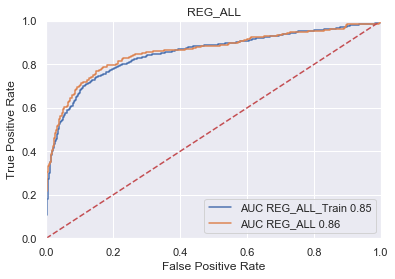

REG_ALL CLASSIFICATION ACCURACY
REG_ALL_Train  =  0.8718003412969283
REG_ALL  =  0.8729752770673487
------




In [55]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

**DAMAGES**

In [56]:
AMT = LinearRegression()
AMT = AMT.fit(w_train, z_train[TARGET_A])

In [57]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train, z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_ALL RMSE ACCURACY
REG_ALL_Train  =  3895.094339813731
REG_ALL  =  4360.171040128948
------




In [58]:
varNames = list(x_train.columns.values )

In [59]:
REG_ALL_DFLT_COEF = getCoefLogit(DFLT, x_train )
REG_ALL_AMT_COEF = getCoefLinear(AMT, x_train )


DEFAULT
---------
Total Variables:  21
INTERCEPT  =  0.44644310718827385
LOAN  =  -1.32411146462894e-05
MORTDUE  =  3.5460872074646773e-06
VALUE  =  -2.94469895895604e-06
YOJ  =  -0.022035469735098064
DEROG  =  0.4929085937116025
DELINQ  =  0.6725895621850867
CLAGE  =  -0.005331700892235892
NINQ  =  0.17275356644435874
CLNO  =  0.0032879134383274233
DEBTINC  =  -0.057749704765397016
REASON_DebtCon  =  -0.10063484694262534
REASON_HomeImp  =  0.21104923357133334
REASON_Missing  =  0.1056311421333986
JOB_Mgr  =  0.1411894941141464
JOB_Missing  =  -1.1658940269519869
JOB_Office  =  -0.5002844798854287
JOB_Other  =  0.21486869213168544
JOB_ProfExe  =  -0.2497655793889872
JOB_Sales  =  1.1698359518233992
JOB_Self  =  0.6060954769192716

LOSS
---------
Total Variables:  21
INTERCEPT  =  -1568.859066279354
LOAN  =  0.7899015186066137
MORTDUE  =  -0.0003739843447146292
VALUE  =  0.005771707529919765
YOJ  =  -58.14540564743474
DEROG  =  308.1832794780282
DELINQ  =  681.9619614344862
CLAGE  =  -

In [60]:
REG_ALL_DFLT = TEST_DFLT.copy()
REG_ALL_AMT = TEST_AMT.copy()

**REGRESSION DECISION TREE**

In [61]:
WHO = "REG_TREE"

In [62]:
DFLT = LogisticRegression(solver='newton-cg', max_iter=1000 )
DFLT = DFLT.fit(x_train[vars_tree_flag], y_train[TARGET_F])

In [63]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train[vars_tree_flag], y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test[vars_tree_flag], y_test[TARGET_F])

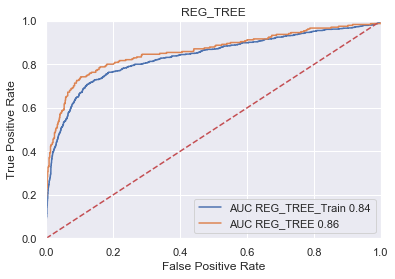

REG_TREE CLASSIFICATION ACCURACY
REG_TREE_Train  =  0.8658276450511946
REG_TREE  =  0.875532821824382
------




In [64]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

**DAMAGES**

In [65]:
AMT = LinearRegression()
AMT = AMT.fit(w_train[vars_tree_amt], z_train[TARGET_A])

In [66]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train[vars_tree_amt], z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test[vars_tree_amt], z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_TREE RMSE ACCURACY
REG_TREE_Train  =  4542.151467044363
REG_TREE  =  5128.3353201719465
------




In [67]:
varNames = list(x_train.columns.values )

In [68]:
REG_TREE_DFLT_COEF = getCoefLogit(DFLT, x_train[vars_tree_flag])
REG_TREE_AMT_COEF = getCoefLinear(AMT, x_train[vars_tree_amt])


DEFAULT
---------
Total Variables:  7
INTERCEPT  =  0.6724781203382588
YOJ  =  -0.02150472468821733
DEROG  =  0.53635073623535
DELINQ  =  0.6650022598622028
CLAGE  =  -0.006143139272392336
DEBTINC  =  -0.059728058070994725
JOB_Missing  =  -1.1504563865236825

LOSS
---------
Total Variables:  4
INTERCEPT  =  -4366.73686528257
LOAN  =  0.8138478478454078
CLNO  =  242.00912575271596
DEBTINC  =  -69.55603937946199


The Decision Tree Regression Analysis we see that customers that have DEROG (Derogatory Marks on Credit Record) and DELINQ (Delinquencies on your current credit report) are more likely to default on their home equity credit. This result makes sense are both of the variables are things that will negatively impact a credit score, thus person's trustability. In addition, we can see that high DEBTINC (debt to income ratio) and CLAGE (credit line age) make a person less likely to default on their home equity credit. 

Our model also shows us that people with higher CLNO (Number of credit lines one have) and LOAN (HMEQ Credit Line) are more likely to cause a higher loss amount on their defaulted credit. On the other hand, higher DEBTINC (debt to income ratio) are less likely to have a high loss amount, which makes sense. 

In [69]:
REG_TREE_DFLT = TEST_DFLT.copy()
REG_TREE_AMT = TEST_AMT.copy()

**REGRESSION RANDOM FOREST**

In [70]:
WHO = "REG_RF"

In [71]:
RF_flag = []
for i in vars_RF_flag :
    print(i)
    theVar = i[0]
    RF_flag.append(theVar)

('DEBTINC', 100)
('CLAGE', 33)
('LOAN', 31)
('DELINQ', 31)
('VALUE', 30)
('CLNO', 26)
('MORTDUE', 24)
('YOJ', 19)


In [72]:
RF_amt = []
for i in vars_RF_amt :
    print(i)
    theVar = i[0]
    RF_amt.append(theVar)

('LOAN', 100)
('CLNO', 12)
('DEBTINC', 8)


In [73]:
DFLT = LogisticRegression(solver='newton-cg', max_iter=1000 )
DFLT = DFLT.fit(x_train[RF_flag],y_train[TARGET_F])

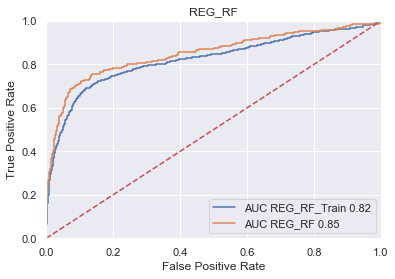

REG_RF CLASSIFICATION ACCURACY
REG_RF_Train  =  0.8611348122866894
REG_RF  =  0.8729752770673487
------




In [74]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train[RF_flag], y_train[TARGET_F] )
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test[RF_flag], y_test[TARGET_F])

print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

**DAMAGES**

In [75]:
AMT = LinearRegression()
AMT = AMT.fit(w_train[RF_amt], z_train[TARGET_A])

In [76]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train[RF_amt], z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test[RF_amt], z_test[TARGET_A])

In [77]:
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_RF RMSE ACCURACY
REG_RF_Train  =  4542.151467044363
REG_RF  =  5128.3353201719465
------




In [78]:
REG_RF_DFLT_COEF = getCoefLogit(DFLT, x_train[RF_flag])
REG_RF_AMT_COEF = getCoefLinear(AMT, x_train[RF_amt])


DEFAULT
---------
Total Variables:  9
INTERCEPT  =  0.927518776374913
DEBTINC  =  -0.06016733448628527
CLAGE  =  -0.006559294022068178
LOAN  =  -7.590294793160134e-06
DELINQ  =  0.7130590056504256
VALUE  =  -3.4149333329619286e-06
CLNO  =  0.008910293673967038
MORTDUE  =  2.51054977905727e-06
YOJ  =  -0.021386157223213936

LOSS
---------
Total Variables:  4
INTERCEPT  =  -4366.73686528257
LOAN  =  0.8138478478454078
CLNO  =  242.00912575271596
DEBTINC  =  -69.55603937946199


With our Random Forest Regression Model we see results that are similar and parallel with Decision Tree regression model. People with high DELINQ and who have MORT_DUE, and have multiple credit lines are the ones that are likely to get their credit default. Esspecially the higher people have a mortgage amount due, the more likely they are to default. On the other hand we see that people with high DEBTINC, CLAGE, House value (VALUE) and LOAN(credit line) are less likely to default. These results correspond with the previous results and makes sense. 

Regarding the LOSS amount, we see that the results are accurate and consistent. People with high LOAN and CLNO are more likely to lose a higher amount on their defaulted credit while people with high DEBTINC are likely to lose a lesser amount on their loan when it gets default. 

In [79]:
REG_RF_DFLT = TEST_DFLT.copy()
REG_RF_AMT = TEST_AMT.copy()

**REGRESSION GRADIENT BOOSTING**

In [80]:
WHO = "REG_GB"

In [81]:
GB_flag = []
for i in vars_GB_flag :
    print(i)
    theVar = i[0]
    GB_flag.append(theVar)

('DEBTINC', 100)
('DELINQ', 17)
('CLAGE', 14)


In [82]:
GB_amt = []
for i in vars_GB_amt :
    print(i)
    theVar = i[0]
    GB_amt.append(theVar)

('LOAN', 100)
('CLNO', 15)
('DEBTINC', 9)


In [83]:
DFLT = LogisticRegression(solver='newton-cg', max_iter=1000)
DFLT = DFLT.fit(x_train[GB_flag], y_train[TARGET_F])

In [84]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, x_train[GB_flag], y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, x_test[GB_flag], y_test[TARGET_F])

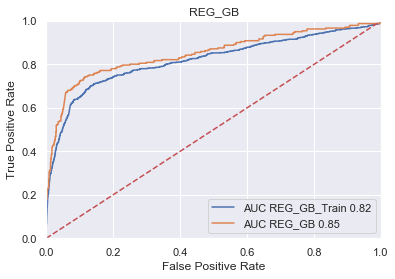

REG_GB CLASSIFICATION ACCURACY
REG_GB_Train  =  0.8624146757679181
REG_GB  =  0.8678601875532822
------




In [85]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

**DAMAGES**

In [86]:
AMT = LinearRegression()
AMT = AMT.fit(w_train[GB_amt], z_train[TARGET_A])

In [87]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, w_train[GB_amt], z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, w_test[GB_amt], z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

REG_GB RMSE ACCURACY
REG_GB_Train  =  4542.151467044363
REG_GB  =  5128.3353201719465
------




In [88]:
REG_GB_DFLT_COEF = getCoefLogit(DFLT, x_train[GB_flag])
REG_GB_AMT_COEF = getCoefLinear(AMT, x_train[GB_amt])


DEFAULT
---------
Total Variables:  4
INTERCEPT  =  0.7033755666581065
DEBTINC  =  -0.06019612353821822
DELINQ  =  0.7193263565314694
CLAGE  =  -0.006878205269428091

LOSS
---------
Total Variables:  4
INTERCEPT  =  -4366.73686528257
LOAN  =  0.8138478478454078
CLNO  =  242.00912575271596
DEBTINC  =  -69.55603937946199


Our gradient boosting regression model have narrowed down the variables that are the most critical in predicting credit default down to three. The results are consistent with our previous models. We see that people with high Debt to income ratio and credit line age are less likely to default while people with high delinquencies on their credit lines are more likely. 

The Loss Amount results remain consistent and reasonable.

In [89]:
REG_GB_DFLT = TEST_DFLT.copy()
REG_GB_AMT = TEST_AMT.copy()

**REGRESSION STEPWISE**

In [ ]:
u_train = x_train[vars_tree_flag]
stepVarNames = list(u_train.columns.values)
maxCols = u_train.shape[1]

In [ ]:
sfs = SFS( LogisticRegression( solver='newton-cg', max_iter=100 ),
           k_features=( 1, maxCols ),
           forward=True,
           floating=False,
           cv=3
           )
sfs.fit(u_train.values, y_train[TARGET_F].values)

In [ ]:
theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)
plt.title('DEFAULT PROBABILITY Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

The Sequential Forward Selection graph we plotted for the default probability shows that the ideal number of variables to include for our analysis is 4 or 5.

In [ ]:
dfm = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

In [ ]:
print(" ................... ")
maxIndex = dfm.avg_score.argmax()
print("argmax")
print( dfm.iloc[ maxIndex, ] )
print(" ................... ")

In [ ]:
stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

In [ ]:
finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

As the sequential forward selection plot showed that the sweet spot is 4 to 5 variables, from the 6 variables listed above we would select the following:

DEROG , DELINQ , CLAGE , DEBTINC , YOJ

We would not choose JOB_Missing as it is a binary variables

In [ ]:
u_train = x_train[finalStepVars]
u_test = x_test[finalStepVars]

In [ ]:
v_train = w_train[GB_amt]
stepVarNames = list(v_train.columns.values)
maxCols = v_train.shape[1]

In [ ]:
sfs = SFS( LinearRegression(),
          k_features=( 1, maxCols ),
           floating=False,
           scoring = 'r2',
           cv=5
           )
sfs.fit(v_train.values, z_train[TARGET_A].values)

In [ ]:
theFigure = plot_sfs(sfs.get_metric_dict(), kind=None)
plt.title('LOSS Sequential Forward Selection (w. StdErr)')
plt.grid()
plt.show()

The Sequential Forward Selection plot for the Loss Amount shows us that 3 variables are ideal for a high performance 

In [ ]:
dfm = pd.DataFrame.from_dict(sfs.get_metric_dict()).T
dfm = dfm[['feature_names', 'avg_score']]
dfm.avg_score = dfm.avg_score.astype(float)

In [ ]:
maxIndex = dfm.avg_score.idxmax()
maxIndex

In [ ]:
stepVars = dfm.iloc[maxIndex, ]
stepVars = stepVars.feature_names
print(stepVars)

In [ ]:
finalStepVars = []
for i in stepVars :
    index = int(i)
    try :
        theName = stepVarNames[ index ]
        finalStepVars.append( theName )
    except :
        pass

for i in finalStepVars :
    print(i)

We would need all three of these variables for our model to best predict the loss amount according to our regression models as well as the sequential forward selection plot.

In [ ]:
v_train = w_train[finalStepVars]
v_test = w_test[finalStepVars]

**STEPWISE REGRESSION**

In [ ]:
WHO = "REG_STEPWISE"

In [ ]:
DFLT = LogisticRegression(solver='newton-cg', max_iter=1000 )
DFLT = DFLT.fit(u_train, y_train[TARGET_F])

In [ ]:
TRAIN_DFLT = getProbAccuracyScores(WHO + "_Train", DFLT, u_train, y_train[TARGET_F])
TEST_DFLT = getProbAccuracyScores(WHO, DFLT, u_test, y_test[TARGET_F])

In [ ]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

**DAMAGES**

In [ ]:
AMT = LinearRegression()
AMT = AMT.fit(v_train, z_train[TARGET_A])

In [ ]:
TRAIN_AMT = getAmtAccuracyScores(WHO + "_Train", AMT, v_train, z_train[TARGET_A])
TEST_AMT = getAmtAccuracyScores(WHO, AMT, v_test, z_test[TARGET_A])
print_Accuracy(WHO + " RMSE ACCURACY", [TRAIN_AMT, TEST_AMT])

In [ ]:
REG_STEP_DFLT_COEF = getCoefLogit(DFLT, u_train)
REG_STEP_AMT_COEF = getCoefLinear(AMT, v_train)

The stepwise regression model gives similar and parallel results with our previous models. People with high DEROG and DELINQ are most likely to default whereas people with higher DEBTINC and YOJ are less likely. The results for Loss Amount are also consistent with previous results

In [ ]:
REG_STEP_DFLT = TEST_DFLT.copy()
REG_STEP_AMT = TEST_AMT.copy()

**LOSS AMOUNT**

In [ ]:
ALL_DFLT = [TREE_DFLT, RF_DFLT, GB_DFLT, REG_ALL_DFLT, REG_TREE_DFLT, REG_RF_DFLT, REG_GB_DFLT, REG_STEP_DFLT]

In [ ]:
ALL_DFLT = sorted(ALL_DFLT, key = lambda x: x[4], reverse=True)
print_ROC_Curve(WHO, ALL_DFLT) 

ALL_DFLT = sorted(ALL_DFLT, key = lambda x: x[1], reverse=True)
print_Accuracy("ALL CLASSIFICATION ACCURACY", ALL_DFLT)

The ROC Curve graph with accuracy of all models we ran shows that our most accurate model is the Random Forest model, followed by the Gradient Boosting model. We see that Regression Model where we used only the Gradient Boosting variables is the least accurate.

While there isn't a drastically significant difference between accuracies of various in classification on the models we ran, we see that random forest and gradient boosting have the higher with 91% whereas Regression model for random forest variables and gradient boosting variables have the lowest accuracy of 87%.

In [ ]:
ALL_AMT = [TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, REG_STEP_AMT]
ALL_AMT = sorted(ALL_AMT, key = lambda x: x[1])
print_Accuracy("ALL DAMAGE MODEL ACCURACY", ALL_AMT)

Best models to predict the Loss Amount are Gradient Boosting, Random Forest and the regression model we ran with all variables. 

Per the above results, I would choose Gradient Boosting Model as it is consistently highly accurate

**TENSORFLOW**

In [233]:
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

import warnings
warnings.filterwarnings("ignore")

In [234]:
theScaler = MinMaxScaler()
theScaler.fit(x_train)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [235]:
def get_TF_ProbAccuracyScores(NAME, MODEL, x, y):
    probs = MODEL.predict(x)
    pred_list = []
    for p in probs:
        pred_list.append(np.argmax(p))
    pred = np.array(pred_list)
    acc_score = metrics.accuracy_score(y, pred)
    p1 = probs[:,1]
    fpr, tpr, threshold = metrics.roc_curve(y, p1)
    auc = metrics.auc(fpr,tpr)
    return [NAME, acc_score, fpr, tpr, auc]

In [236]:
WHO = "Tensor_Flow"

#create new test and train set that are transformed 
u_train = theScaler.transform(x_train)
u_test = theScaler.transform(x_test)

#turn them into data frames
u_train = pd.DataFrame(u_train)
u_test = pd.DataFrame(u_test)

#add column names
u_train.columns = list(x_train.columns.values)
u_test.columns = list(x_train.columns.values)

#we make the set to be smaller with less variables, only Gradient Boosting model Flag items
u_train = u_train[RF_flag]
u_test = u_test[RF_flag]

u_train.head().T

,0,1,2,3,4
DEBTINC,0.148928,0.186302,0.191895,0.197268,0.000000
CLAGE,0.222773,0.108220,0.109281,0.299336,0.150284
LOAN,0.245495,0.190315,0.163288,0.397523,0.094595
DELINQ,0.000000,0.000000,0.000000,0.000000,0.066667
VALUE,0.660519,0.394239,0.352171,0.439388,0.273933
CLNO,0.380282,0.422535,0.338028,0.267606,0.169014
MORTDUE,0.706052,0.435708,0.359999,0.373731,0.298957
YOJ,0.048780,0.000000,0.073171,0.731707,0.219512


We will be using the Random Forest model variables (8 variables in total) for our TensorFlow Neural Networks model as RF has been the most accurate model we have ran so far. 

In [237]:
#size of the dataset
F_theShapeSize = u_train.shape[1]

F_theActivation = tf.keras.activations.relu
#Crossentropy because we transformed the values
F_theLossMetric = tf.keras.losses.SparseCategoricalCrossentropy()
F_theOptimizer = tf.keras.optimizers.Adam()
#going through the data 100 times
F_theEpochs = 100

In [238]:
#hidden layers = two times the number of input variables
F_theUnits = int(2*F_theShapeSize)
#rule of thumb

We will use two hidden layers in our model. We will not be using more than 2 hidden layers to avoid overfitting.

In [239]:
F_LAYER_01 = tf.keras.layers.Dense(units=F_theUnits, activation=F_theActivation, input_dim=F_theShapeSize)
F_LAYER_DROP = tf.keras.layers.Dropout(0.2)
F_LAYER_02 = tf.keras.layers.Dense( units=F_theUnits, activation=F_theActivation )
F_LAYER_OUTPUT = tf.keras.layers.Dense( units=2, activation=tf.keras.activations.softmax )
#more than two hidden layers may cause over-fitting, so we will stick with one hidden layer

Now that we have out layer set, we will create our NN model below:

In [240]:
DFLT = tf.keras.Sequential()
DFLT.add(F_LAYER_01)
DFLT.add(F_LAYER_DROP)
DFLT.add(F_LAYER_02)
DFLT.add(F_LAYER_OUTPUT)
DFLT.compile(loss=F_theLossMetric, optimizer=F_theOptimizer)
DFLT.fit(u_train, y_train[TARGET_F], epochs=F_theEpochs, verbose=False )

In [241]:
TRAIN_DFLT = get_TF_ProbAccuracyScores(WHO + "_Train", DFLT, u_train, y_train[TARGET_F])
TEST_DFLT = get_TF_ProbAccuracyScores(WHO, DFLT, u_test, y_test[TARGET_F])

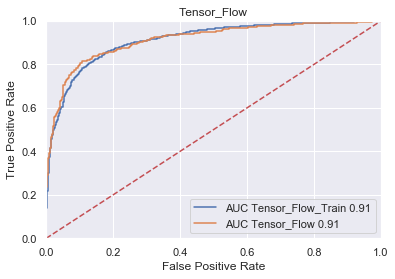

Tensor_Flow CLASSIFICATION ACCURACY
Tensor_Flow_Train  =  0.8873720136518771
Tensor_Flow  =  0.8985507246376812
------




In [242]:
print_ROC_Curve(WHO, [TRAIN_DFLT, TEST_DFLT]) 
print_Accuracy(WHO + " CLASSIFICATION ACCURACY", [TRAIN_DFLT, TEST_DFLT])

Above is the ROC Curve graph for our NN model as well as the classification accuracy for both TensorFlow training and test datasets. We only see a 1% difference between the accuracies of our train and test data sets, which can be considered a positive outcome. While, compared to previous models we ran, the NN model is not the most accurate model in predicting the porobability of home equity credit default, it performed better than our regression models.

Below, we will run the NN model to predict the 'amount' of loss in case of a defaulted credit.

In [243]:
v_train = theScaler.transform(w_train)
v_test = theScaler.transform(w_test)

v_train = pd.DataFrame(v_train)
v_test = pd.DataFrame(v_test)

v_train.columns = list(w_train.columns.values )
v_test.columns = list(w_train.columns.values )

v_train = v_train[RF_amt]
v_test = v_test[RF_amt]

As we did in our NN model where we ran for 'credit default' in our model where we will be predicting the amount of los, we will also use the Random Forest model variables

In [244]:
A_theShapeSize = v_train.shape[1]
A_theActivation = tf.keras.activations.relu
A_theLossMetric = tf.keras.losses.MeanSquaredError()
A_theOptimizer = tf.keras.optimizers.Adam()
A_theEpochs = 800

In [245]:
A_theUnits = int( 2*A_theShapeSize  )

We will again be using two layers

In [246]:
A_LAYER_01 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation, input_dim=A_theShapeSize )
A_LAYER_DROP = tf.keras.layers.Dropout(0.2)
A_LAYER_02 = tf.keras.layers.Dense( units=A_theUnits, activation=A_theActivation )
A_LAYER_OUTPUT = tf.keras.layers.Dense( units=1, activation=tf.keras.activations.linear )

In [247]:
AMT = tf.keras.Sequential()
AMT.add( A_LAYER_01 )
AMT.add( A_LAYER_DROP )
AMT.add( A_LAYER_02 )
AMT.add( A_LAYER_OUTPUT )
AMT.compile( loss=A_theLossMetric, optimizer=A_theOptimizer)
AMT.fit(v_train,z_train[TARGET_A], epochs=A_theEpochs, verbose=False )

In [248]:
TRAIN_AMT = getAmtAccuracyScores( WHO + "_Train", AMT, v_train[RF_amt], z_train[TARGET_A] )
TEST_AMT = getAmtAccuracyScores( WHO, AMT, v_test[RF_amt], z_test[TARGET_A] )
print_Accuracy( WHO + " RMSE ACCURACY", [ TRAIN_AMT, TEST_AMT ] )

TF_DFLT = TEST_DFLT.copy()
TF_AMT = TEST_AMT.copy()

Tensor_Flow RMSE ACCURACY
Tensor_Flow_Train  =  5925.266260516274
Tensor_Flow  =  5760.516768307663
------




Above we see that the RMSE accuracy between train and test dataset as the given amount of loss for each model is significantly close to one another. Our training model gave us the output of 5,925 dollars loss in case of a defaulted credit while our test model gave 5,761 dollars. With this outcome we can comfortable determine that in case of a defaulted home equity credit, the loss amount will be between 5,500 and 6,000 dollars through our NN model.

Finally, let's plot all models we built to predict the 'credit default'

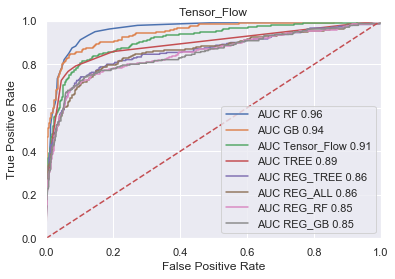

ALL CLASSIFICATION ACCURACY
RF  =  0.9190110826939472
GB  =  0.9121909633418585
TREE  =  0.9036658141517476
Tensor_Flow  =  0.8985507246376812
REG_TREE  =  0.875532821824382
REG_ALL  =  0.8729752770673487
REG_RF  =  0.8729752770673487
REG_GB  =  0.8678601875532822
------




In [249]:
ALL_DFLT = [ TREE_DFLT, RF_DFLT, GB_DFLT, REG_ALL_DFLT, REG_TREE_DFLT, REG_RF_DFLT, REG_GB_DFLT, TF_DFLT]

ALL_DFLT = sorted( ALL_DFLT, key = lambda x: x[4], reverse=True )
print_ROC_Curve(WHO, ALL_DFLT) 

ALL_DFLT = sorted( ALL_DFLT, key = lambda x: x[1], reverse=True )
print_Accuracy( "ALL CLASSIFICATION ACCURACY", ALL_DFLT)

As seen above, our most accurate predictive model that we ran for the HMEQ dataset is still the Random Forest model, followed by Gradient Boosting, Decision Tree and Neural Networks (TensorFlow) models. Even though NN model gave us solid predictions, with 88% accuracy on credit default prediction, still behind RF, GB and Tree models in highest to lowest model accuracy listed above. 

In [250]:
ALL_AMT = [ TREE_AMT, RF_AMT, GB_AMT, REG_ALL_AMT, REG_TREE_AMT, REG_RF_AMT, REG_GB_AMT, TF_AMT ]
ALL_AMT = sorted( ALL_AMT, key = lambda x: x[1] )
print_Accuracy( "ALL DAMAGE MODEL ACCURACY", ALL_AMT )

ALL DAMAGE MODEL ACCURACY
GB  =  3149.092174701888
RF  =  4295.973809056954
REG_ALL  =  4360.171040128948
REG_TREE  =  5128.3353201719465
REG_RF  =  5128.3353201719465
REG_GB  =  5128.3353201719465
Tensor_Flow  =  5760.516768307663
TREE  =  6065.25844508915
------




Finally, per the above list of 'loss amount' per each model, we can conclude that the amount that our NN model has provided us is on the higher end of the spectrum. The other models we ran that had a higher accuracy such as Gradient Boosting and Random Forest given us a loss amount that is likely to be in the range of 3,000 and 4,500 dollar, while our NN model gives us an amount in the high 5,000s. The NN model outcome seem to be in the cluster of 'loss amount' group with the Regression models. This outcome is accurate with the DFLT model accuracy, yet may be considered as a none ideal result. 